# Install

In [4]:
!pip install -q google-cloud-storage==1.43.0
!pip install -q pyspark
!pip install -U -q PyDrive
!apt-get update -qq
!apt install openjdk-8-jdk-headless -qq

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.


In [5]:
!pip install -q google-cloud-storage==1.43.0

# Imports, constants and data

Imports

In [6]:
from google.cloud import storage
from google.cloud import *

from imports import *
from builtins import *

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.sql import SQLContext

Bucket stuff

In [7]:
from inverted_index_colab import *

In [8]:
bucket_name = '316431873' 

In [9]:
path = "postings_gcp_anc"
client = storage.Client.from_service_account_json("optimistic-jet-334418-efae840be978.json")

In [52]:
bucket = client.bucket(bucket_name)
blobs = client.list_blobs(bucket_name)

Indexes

In [10]:
# import pickle
with open( f'{"index_text"}.pkl', 'rb') as f:
  index_body  = pickle.load(f)
with open( f'{"title_index"}.pkl', 'rb') as f:
  index_title  = pickle.load(f)
with open( f'{"indexses_index_anc"}.pkl', 'rb') as f:
  index_anchor  = pickle.load(f)

In [11]:
with open( f'{"Dl_body"}.pkl', 'rb') as f:
  DL_body  = pickle.load(f)
with open( f'{"dl_title"}.pkl', 'rb') as f:
  DL_title  = pickle.load(f)
with open( f'{"id_title_dict"}.pkl', 'rb') as f:
  id_title_dict  = pickle.load(f)

In [12]:
index_title.path = "postings_gcp_title"
index_anchor.path =  "postings_gcp_anc"
index_body.path = "postings_gcp_text"

index_title.words = set(index_title.df.keys())
index_anchor.words =  set(index_anchor.df.keys())
index_body.words = set(index_body.df.keys())

# Read posting list

In [13]:
TUPLE_SIZE = 6
BLOCK_SIZE = 1999998

def read_posting(word, index):
    client = storage.Client.from_service_account_json("optimistic-jet-334418-efae840be978.json")
    bucket = client.bucket(bucket_name)
    b = []
    posting_list = [] 
    df = index.df[word]
    with closing(MultiFileReader()) as reader:
        locs = index.posting_locs[word]
        n_bytes = index.df[word] * TUPLE_SIZE
#         b = reader.read(locs, n_bytes)
        for f_name, offset in locs:
                post_before = ""
                blob = bucket.blob(f"{index.path}/{f_name}")
                blob.download_to_filename("yo")
                f = open("yo" , 'rb')
                f.seek(offset)
                lst = [n_bytes , BLOCK_SIZE - offset]
                if lst[0] <= (BLOCK_SIZE - offset):
                    n_read = n_bytes
                else: 
                    n_read = BLOCK_SIZE - offset

                b.append(f.read(n_read))
                n_bytes -= n_read
                post_before = b''.join(b)
                for i in range(df):
                    doc_id = int.from_bytes(post_before[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
                    tf = int.from_bytes(post_before[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
                    posting_list.append((doc_id, tf))
        return posting_list

In [14]:
def read_posting_anchor(word, index):
    client = storage.Client.from_service_account_json("optimistic-jet-334418-efae840be978.json")
    bucket = client.bucket(bucket_name)
    b = []
    posting_list = [] 
    df = index.df[word]
    with closing(MultiFileReader()) as reader:
        locs = index.posting_locs[word]
        n_bytes = index.df[word] * TUPLE_SIZE
#         b = reader.read(locs, n_bytes)
        for f_name, offset in locs:
                post_before = ""
                blob = bucket.blob(f"{index.path}/{f_name}")
                blob.download_to_filename("yo")
                f = open("yo" , 'rb')
                f.seek(offset)
                lst = [n_bytes , BLOCK_SIZE - offset]
                if lst[0] <= (BLOCK_SIZE - offset):
                    n_read = n_bytes
                else: 
                    n_read = BLOCK_SIZE - offset

                b.append(f.read(n_read))
                n_bytes -= n_read
                post_before = b''.join(b)
                for i in range(df):
                    doc_id = int.from_bytes(post_before[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
                    tf = int.from_bytes(post_before[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
                    posting_list.append((doc_id, tf))
        return list(set(posting_list))

# Import queries

In [2]:
import json
from sklearn.model_selection import train_test_split

In [3]:
f = open('queries_train.json')
''' 
    queries_to_relavent_docs is a dictionary of length 30 with -
          key: query (str)
          value: list of relavent documents id's (list)
'''
queries_to_relavent_docs = json.load(f)
f.close()

'''10 test queries and 20 train queries'''
train_queries, test_queries = train_test_split(list(queries_to_relavent_docs.keys()), test_size=10, shuffle=True)
all_queries = list(queries_to_relavent_docs.keys())

# Preprossesing

In [15]:
from nltk.corpus import stopwords
nltk.download('stopwords')

english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links", 
                    "may", "first", "see", "history", "people", "one", "two", 
                    "part", "thumb", "including", "second", "following", 
                    "many", "however", "would", "became"]
corpus_stopwords = set(corpus_stopwords)
all_stopwords = english_stopwords.union(corpus_stopwords)
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)

def query_preprosess(text):
  ''' 
  -----------
    text: str
      Text of one document
    id: int
      Document id
  Returns:
  --------
    List of tuples
      A list of (token, (doc_id, tf)) pairs 
      for example: [("Anarchism", (12, 5)), ...]
  '''
  tokens = [token.group() for token in RE_WORD.finditer(text.lower())]
  ans = [word for word in tokens if word not in all_stopwords]
  return ans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Search anchor binary


In [61]:
def search_anchor(query_tokens, index):
  relavent_docs = {}
  for term in np.unique(query_tokens):
    if term in index.words:
      list_of_docs = read_posting_anchor(term, index)
      for dest_id, flag in list_of_docs:
          if dest_id == 0:
            continue
          #print(dest_id)
          relavent_docs[dest_id] = relavent_docs.get(dest_id,0) + 1
  relavent_docs_list_sorted = sorted(relavent_docs.keys(), key = lambda doc_id: - relavent_docs[doc_id])
  relavent_docs_list_sorted_with_title = [(i, id_title_dict[i]) for i in relavent_docs_list_sorted]
  return relavent_docs_list_sorted_with_title

In [62]:
def search_anchor_for_opt(query_tokens, index):
  relavent_docs = {}
  for term in np.unique(query_tokens):
    if term in index.words:
      list_of_docs = read_posting_anchor(term, index)
      for dest_id, flag in list_of_docs:
          if dest_id == 0:
            continue
          #print(dest_id)
          relavent_docs[dest_id] = relavent_docs.get(dest_id,0) + 10
  return relavent_docs

# Search title binary

In [63]:
def search_title(query_tokens, index):
  relavent_docs = {}
  for term in np.unique(query_tokens):
    if term in index.words:
      list_of_docs = read_posting(term, index)
      for doc_id, freq in list_of_docs:
        if doc_id == 0:
          continue
        relavent_docs[doc_id] = relavent_docs.get(doc_id,0) + 1
  relavent_docs_list_sorted = sorted(relavent_docs.keys(), key = lambda doc_id: - relavent_docs[doc_id])[:100] # 100 max!!
  relavent_docs_list_sorted_with_title = [(i, id_title_dict[i]) for i in relavent_docs_list_sorted]
  return relavent_docs_list_sorted_with_title

In [64]:
len(search_title(["python", "code", "script"], index_title))

100

# Page rank

In [17]:
import csv
pagerank_dict = dict()
with open('pagerank.csv', mode='r') as infile:
    reader = csv.reader(infile)
    for rows in reader:
      try:
        pagerank_dict[int(rows[0])] = float(rows[1])
      except:
        print(int(rows[0]))

normelize

In [66]:
norm_pagerank_dict = dict()


sum_before = 0
sum_after = 0
length = len(pagerank_dict)
key_median = list(pagerank_dict.keys())[int(length / 2)]
median_before = pagerank_dict[key_median]
for page in pagerank_dict:
  sum_before += pagerank_dict[page]
  norm_pagerank_dict[page] = np.sqrt(pagerank_dict[page]) / 3
  sum_after += norm_pagerank_dict[page]
median_after = norm_pagerank_dict[key_median]

In [ ]:
mean_before = sum_before / length
mean_after = sum_after / length
print(mean_before)
print(mean_after)
print(median_before)
print(median_after)
print(max(list(norm_pagerank_dict.values())))
print(min(list(norm_pagerank_dict.values())))

1.0000000000249587
0.23109642975427994
0.2515575284859404
0.16718503670615328


exe on list

In [ ]:
def get_page_rank_by_id(id):
    return pagerank_dict[id]

vec_get_page_rank_by_id = np.vectorize(get_page_rank_by_id)

In [ ]:
def get_page_rank(articles_ids):
    articles_ids = np.array(articles_ids)
    ans = vec_get_page_rank_by_id(articles_ids)
    return list(ans)

#Inverted tf-idf Cosine

title

In [68]:
N = 6348910 # num of documents in the curpus
to_return = 100
def inverted_cosine_similaruty_tfidf_title(query_tokens,index):
  similarity_dict = dict() # doc_id : cosine similarity
  query_w = Counter(query_tokens) # weights of words in the query
  query_norm = 1 / len(query_tokens) # 1 / |q|
  docs_norm = dict() # doc_id: 1 / |di|
  for term in set(query_tokens):
    if term in index.words:
      query_term_w = query_w[term]
      posting_list = read_posting(term, index)
      df = index.df[term]
      idf = np.log(N / df)
      for doc_id, freq in posting_list:
        if doc_id == 0:
          continue
        docs_norm[doc_id] = 1 / DL_body[doc_id]
        tf = freq / DL_body[doc_id] # TODO: title DL
        w = tf * idf
        similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w * query_term_w
  for doc_id in similarity_dict.keys():
    similarity_dict[doc_id] = similarity_dict[doc_id] * query_norm * docs_norm[doc_id]
  similarity_list = similarity_dict.items() # [(doc_id, similarity_score)]
  sorted_similarity_list = sorted(similarity_list, key = lambda x: -x[1])[:to_return]
  sorted_similarity_list_with_title = [(doc[0], id_title_dict[doc[0]]) for doc in sorted_similarity_list]
  return sorted_similarity_list_with_title

body

In [69]:
N = 6348910 # num of documents in the curpus
to_return = 100
def inverted_cosine_similaruty_tfidf_body(query_tokens,index):
  similarity_dict = dict() # doc_id : cosine similarity
  query_w = Counter(query_tokens) # weights of words in the query
  #query_norm = 1 / len(query_tokens) # 1 / |q|
  #docs_norm = dict() # doc_id: 1 / |di|
  for term in set(query_tokens):
    if term in index.words:
      query_term_w = query_w[term]
      posting_list = read_posting(term, index)
      df = index.df[term]
      idf = np.log(N / df)
      for doc_id, freq in posting_list:
        if doc_id == 0:
          continue
        #docs_norm[doc_id] = 1 / DL_title[doc_id]
        tf = freq / DL_body[doc_id] # TODO: title DL
        w = tf * idf
        similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w * query_term_w
  for doc_id in similarity_dict.keys():
    similarity_dict[doc_id] = similarity_dict[doc_id]# * query_norm * docs_norm[doc_id]
  similarity_list = similarity_dict.items() # [(doc_id, similarity_score)]
  sorted_similarity_list = sorted(similarity_list, key = lambda x: -x[1])[:to_return]
  sorted_similarity_list_with_title = [(doc[0], id_title_dict[doc[0]]) for doc in sorted_similarity_list]
  return sorted_similarity_list_with_title

In [ ]:
#print(read_posting("python",index_body))
query = train_queries[4]
print(query)
query = query_preprosess(query)
print(query)
inverted_cosine_similaruty_tfidf_body(query, index_body)

# Get pageview

In [18]:
PAGE_VIEW_FILE_NAME = "pageviews-202108-user.pkl"
with open(PAGE_VIEW_FILE_NAME, 'rb') as f:
  pageviews_dict = pickle.loads(f.read())


def get_page_view_by_id(id):
    return pageviews_dict[id]

vec_get_page_rank_by_id = np.vectorize(get_page_view_by_id)

# Function def
def get_pageview_beckend(articles_ids):
  num_articles = len(articles_ids)
  ans = [0 for i in range(num_articles)]
  for i in range(num_articles):
    article_id = articles_ids[i]
    ans[i] = pageviews_dict[article_id]
  return ans

In [72]:
def get_page_view(articles_ids):
    articles_ids = np.array(articles_ids)
    ans = vec_get_page_rank_by_id(articles_ids)
    return list(ans)

In [73]:
test_articles = [5878274, 7712754, 3632887, 600744, 59804426, 63743203, 34443176, 4838455, 11011780, 4822278]
print(get_page_view(test_articles))

[52, 28713, 528, 4285, 61650, 23, 7, 1450, 9, 779]


Normelize

In [74]:
norm_pageviews_dict = dict()


sum_before = 0
sum_after = 0
length = len(pageviews_dict)
key_median = list(pageviews_dict.keys())[int(length / 2)]
median_before = pageviews_dict[key_median]
for page in pageviews_dict:
  sum_before += pageviews_dict[page]
  norm_pageviews_dict[page] = pageviews_dict[page] ** (0.25) / 3
  sum_after += norm_pageviews_dict[page]
median_after = norm_pageviews_dict[key_median]

In [75]:
mean_before = sum_before / length
mean_after = sum_after / length
print(mean_before)
print(mean_after)
print(median_before)
print(median_after)

print(max(list(norm_pageviews_dict.values())))
print(min(list(norm_pageviews_dict.values())))

674.0488855666746
0.8637079469246546
9
0.5773502691896257


KeyboardInterrupt: ignored

# BM25

title

In [76]:
num_docs = len(DL_title)

sum_lengths = 0
for val in DL_title.keys(): sum_lengths += DL_title[val]

avgdl_title = sum_lengths / num_docs

K1 = 1.5
B = 0.75

In [77]:
def inverted_BM25_similaruty_title(query_tokens,index, k1, b):
  N = 6348910 # num of documents in the curpus
  similarity_dict = dict() # doc_id : cosine similarity

  for term in query_tokens:
    if term in index.words:
      posting_list = read_posting(term, index)

      df = index.df[term]
      q_i_IDF = np.log((N - df + 0.5) / (df + 0.5) + 1)

      for doc_id, freq in posting_list:
        if doc_id == 0:#TODO: ?
          continue
        f_ti_D = freq
        #print(doc_id)
        len_of_D = DL_title[doc_id]
        w = q_i_IDF * ((f_ti_D * (k1 + 1)) / (f_ti_D + k1 * (1 - b + b * (len_of_D / avgdl_title))))
        similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w
  return similarity_dict # TODO: change
  similarity_list = similarity_dict.items() # [(doc_id, similarity_score)]
  sorted_similarity_list = sorted(similarity_list, key = lambda x: -x[1])[:100]
  sorted_similarity_list_with_title = [(doc[0], id_title_dict[doc[0]]) for doc in sorted_similarity_list]
  return sorted_similarity_list_with_title

body

In [78]:
num_docs = len(DL_body)

sum_lengths = 0
for val in DL_body.keys(): sum_lengths += DL_body[val]

avgdl_body = sum_lengths / num_docs

K1 = 1.5
B = 0.75

In [79]:
def inverted_BM25_similaruty_body(query_tokens,index, k1, b):
  N = 6348910 # num of documents in the curpus
  similarity_dict = dict() # doc_id : cosine similarity

  for term in query_tokens:
    if term in index.words:
      posting_list = read_posting(term, index)

      df = index.df[term]
      q_i_IDF = np.log((N - df + 0.5) / (df + 0.5) + 1)

      for doc_id, freq in posting_list:
        if doc_id == 0:#TODO: ?
          continue
        f_ti_D = freq
        #print(doc_id)
        len_of_D = DL_body[doc_id]
        w = q_i_IDF * ((f_ti_D * (k1 + 1)) / (f_ti_D + k1 * (1 - b + b * (len_of_D / avgdl_body))))
        similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w
  return similarity_dict # TODO: change
  similarity_list = similarity_dict.items() # [(doc_id, similarity_score)]
  sorted_similarity_list = sorted(similarity_list, key = lambda x: -x[1])[:100]
  sorted_similarity_list_with_title = [(doc[0], id_title_dict[doc[0]]) for doc in sorted_similarity_list]
  return sorted_similarity_list_with_title

In [80]:
#expiraments_result_dict_title = dict() # #expirament : {description: , MAP@40: , mean time:}

# Evaluate

In [22]:
def precision_at_k(true_list,predicted_list,k=40):      
    predicted_list = predicted_list[:k]
    true = set(true_list)
    pred = set(predicted_list)
    relavent_pred = true.intersection(pred)
    recall_score = len(relavent_pred) / len(pred)
    return recall_score

In [23]:
def average_precision(true_list,predicted_list,k=40):
    num_found = 0
    sum_precision = 0
    k = min([k, len(predicted_list)])
    for i in range(k):
      if predicted_list[i] in true_list:
        sum_precision += precision_at_k(true_list,predicted_list,k = i + 1)
        num_found += 1
    if num_found != 0:
      ans = (1/num_found) * sum_precision
    else:
      ans = 0.0
    return ans

In [24]:
def mean_average_precision(true_dict,predicted_dict,k=40):
    """
    Parameters
    -----------
    true_dict: query_id : list of relevant documents. Each element is a doc_id.
    predicted_list: query_id : sorted list of documents predicted as relevant. Each element is a doc_id.
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, average precision@k.
    """
    num_queries = len(true_dict)
    #print(num_queries)
    mean = 0
    for query_id in true_dict.keys():
      mean += average_precision(true_dict[query_id],predicted_dict[query_id],k=40)
      #print(mean)
    mean = mean / num_queries
    return mean

# Optimization

Title expiraments

In [84]:
#expiraments_result_dict_body = dict()

In [ ]:
import time
pred_dict = dict()
true_dict = dict()

K1 = 2
B = 1
mean_time = 0
time_zero = time.time()
for i in range(len(train_queries)):
  current_time = time.time()
  query = train_queries[i]
  query_tekens = query_preprosess(query)
  result = inverted_BM25_similaruty_title(query_tekens,index_title, K1, B) # expirament that changes
  retrival_time = time.time() - current_time
  print(query, retrival_time)
  mean_time += retrival_time
  #print(result)
  pred_dict[i] = [x for x in result]
  true_dict[i] = queries_to_relavent_docs[query]

mean_time = mean_time/len(train_queries)
print("total time:", time.time() - time_zero)

In [ ]:
result = mean_average_precision(true_dict,pred_dict,k=40)
print("mean_time", mean_time)
print("MAP@40:", result)

In [ ]:
from builtins import *
expirament_id = 5
expirament_description = "BM25 k1=2, B=1"
result = mean_average_precision(true_dict,pred_dict,k=40)
print("mean_time", mean_time)
print("MAP@40:", result)
expiraments_result_dict_title[expirament_id] = dict()
expiraments_result_dict_title[expirament_id]["description"] = expirament_description
expiraments_result_dict_title[expirament_id]["MAP@40"] = result
expiraments_result_dict_title[expirament_id]["mean time"] = mean_time
print(expiraments_result_dict_title[expirament_id])

In [ ]:
print(expiraments_result_dict_title)

BM25 title parameters

In [ ]:
from builtins import *
import time

train_queries_tokens = [query_preprosess(query) for query in train_queries]

start_time = time.time()

k1_opt = np.linspace(0.0, 3.0, num=10)
b_opt = np.linspace(0.0, 1.0, num=10)

scores_dict = dict()
counter = 0
for k1 in k1_opt:
  for b in b_opt:

    pred_dict = dict() # query_id : predicted list
    true_dict = dict()

    for i in range(len(train_queries)):
      query = train_queries[i]
      query_tekens = query_preprosess(query)
      #print(query_tekens)
      model = inverted_BM25_similaruty(query_tekens, index_title, k1, b)
      pred_dict[i] = [x[0] for x in model]
      true_dict[i] = queries_to_relavent_docs[query]

    scores_dict[(k1, b)] = mean_average_precision(true_dict,pred_dict,k=40)
    print(counter, time.time() - start_time)
    counter += 1

In [ ]:
rank = sorted(scores_dict.keys(), key = lambda x: -scores_dict[x])
for i in rank:
  print("k1:", i[0], "b:", i[1], "score:", scores_dict[i])

In [ ]:
from imports import *

pred_dict = dict()
true_dict = dict()

for i in range(len(train_queries)):
  query = train_queries[i]
  query_tekens = query_preprosess(query)
  pred_dict[i] = [x[0] for x in inverted_cosine_similaruty_tfidf_title(query_tekens,index_title)]
  true_dict[i] = queries_to_relavent_docs[query]


In [ ]:
from builtins import *
mean_average_precision(true_dict,pred_dict,k=40)

In [ ]:
print(rank[:10])

# Merge title, body, anchor scores

train

In [86]:
train_queries_dict = dict() # query_id : query string
for i in range(len(train_queries)): train_queries_dict[i] = train_queries[i]

In [87]:
train_queries_dict_title = dict() # query_id : BM25 title
for i in range(len(train_queries)):
   query_tekens = query_preprosess(train_queries[i])
   train_queries_dict_title[i] = inverted_BM25_similaruty_title(query_tekens,index_title, 2, 1)

In [88]:
train_queries_dict_body = dict() # query_id : BM25 body
for i in range(len(train_queries)):
   query_tekens = query_preprosess(train_queries[i])
   train_queries_dict_body[i] = inverted_BM25_similaruty_body(query_tekens,index_body, 1, 0.222)

In [89]:
train_queries_dict_anchor = dict()
for i in range(len(train_queries)):
   query_tekens = query_preprosess(train_queries[i])
   train_queries_dict_anchor[i] = search_anchor_for_opt(query_tekens, index_anchor)

In [ ]:
for i in range(len(train_queries_dict)):  
  print(max(train_queries_dict_body[i].values()))
  print(min(train_queries_dict_body[i].values()))

test

In [ ]:
test_queries_dict = dict()# query_id : query string
for i in range(len(test_queries)): test_queries_dict[i] = test_queries[i]

In [ ]:
test_queries_dict_title = dict()# query_id : BM25 title
for i in range(len(test_queries)):
   query_tekens = query_preprosess(test_queries[i])
   test_queries_dict_title[i] = inverted_BM25_similaruty_title(query_tekens,index_title, 2, 1)

In [ ]:
test_queries_dict_body = dict()# query_id : BM25 body
for i in range(len(test_queries)):
   query_tekens = query_preprosess(test_queries[i])
   test_queries_dict_body[i] = inverted_BM25_similaruty_body(query_tekens,index_body, 1, 0.222)

In [ ]:
test_queries_dict_anchor = dict()
for i in range(len(test_queries)):
   query_tekens = query_preprosess(test_queries[i])
   test_queries_dict_anchor[i] = search_anchor_for_opt(query_tekens, index_anchor)

scores dict

In [90]:
# scores_dict = {"title" : train_queries_dict_title, "body": train_queries_dict_body, "pageview" : wid2pv}
test = False

if test:
  scores_dict = {"title" : test_queries_dict_title, "body": test_queries_dict_title}
else:
  scores_dict = {"title" : train_queries_dict_body, "body": train_queries_dict_body, "anchor": train_queries_dict_anchor , "pageview": norm_pageviews_dict, "pagerank": norm_pagerank_dict}

''' Each dict is a query_id : [list of pairs in the following format:(doc_id,score)]'''

' Each dict is a query_id : [list of pairs in the following format:(doc_id,score)]'

In [91]:
def merge_results(scores_dict, weights_dict, return_as_predictedlist = False):    
    """
    outnput: 
        united_dict - query_id: {doc_id : united_score}

        if return_as_predictedlist:
          united_dict - query_id: [list of sorted doc_ids by united score]
    """
    united_dict = dict()
    query_ids = list(scores_dict["title"].keys())
    score_types = list(scores_dict.keys())

    # # from tuple (doc_id,score) to dict doc_id: score
    # for score_type in score_types:
    #   for query_id in query_ids:
    #     scores_dict[score_type][query_id] = dict(scores_dict[score_type][query_id])

    for query_id in query_ids:
      # united for query:
      united_dict[query_id] = dict() 

      # all relavent docs for query:
      doc_ids = set()
      for score_type in score_types:
        if score_type in ["pageview", "pagerank"]:
          continue
        else:
          doc_ids = doc_ids.union(set(scores_dict[score_type][query_id].keys()))

      # calc united score
      for doc_id in doc_ids:
        doc_united_score = 0
        for score_type in score_types: 
          w = weights_dict[score_type]
          if score_type in ["pageview", "pagerank"]:
            if doc_id in scores_dict[score_type]:
            # print(scores_dict[score_type][doc_id])
            # print(w)
              #print("this", wid2pv[doc_id])
              doc_united_score += scores_dict[score_type][doc_id] * w
          elif doc_id in scores_dict[score_type][query_id]:
            doc_united_score += scores_dict[score_type][query_id][doc_id] * w
        united_dict[query_id][doc_id] = doc_united_score

    if return_as_predictedlist:
      for query_id in query_ids:
        united_dict[query_id] = sorted(list(united_dict[query_id].keys()), key = lambda x: -united_dict[query_id][x])

    return united_dict

try on

In [ ]:
united = merge_results(scores_dict, weights_dict, return_as_predictedlist = True)
united

In [ ]:
united[0]

In [ ]:
pred_dict = dict()
true_dict = dict()

for i in train_queries_dict:
    pred_dict[i] = united[i]
    true_dict[i] = queries_to_relavent_docs[train_queries_dict[i]]

In [ ]:
mean_average_precision(true_dict,pred_dict,k=40)

Choose weights

In [92]:
from builtins import *
import time
import numpy as np


start_time = time.time()

w_title_opt = np.linspace(0.0, 1.0, num=5)
w_body_opt = np.linspace(0.0, 1.0, num=5)
#print(np.flipud(w_title_opt))
w_title_opt = [0.1111]
w_body_opt = [0.8888]
w_title_opt = [1]
w_body_opt = [1]
w_anchor_opt = [1]
w_view_opt = [2]
w_rank_opt = [1]

max_score = 0

united_scores_dict = dict()
counter = 0
for w_title in w_title_opt:
  for w_body in w_body_opt:
    for w_anchor in w_anchor_opt:
      for w_view in w_view_opt:
        for w_rank in w_rank_opt:
    #for w_page in w_page_opt:

            pred_dict = dict() # query_id : predicted list
            true_dict = dict()


            # weights_dict = {"title" : w_title, "body": w_body, "pageview": w_page}
            weights_dict = {"title" : w_title, "body": w_body, "anchor": w_anchor , "pageview": w_view, "pagerank": w_rank}
            united = merge_results(scores_dict, weights_dict, return_as_predictedlist = True)
            if test:
              for i in test_queries_dict:
                pred_dict[i] = united[i]
                true_dict[i] = queries_to_relavent_docs[test_queries_dict[i]]
            else:
              for i in train_queries_dict:
                pred_dict[i] = united[i]
                true_dict[i] = queries_to_relavent_docs[train_queries_dict[i]]

            score = mean_average_precision(true_dict,pred_dict,k=40) 
            #united_scores_dict[(w_title, w_body, w_anchor, w_view, w_rank)] = mean_average_precision(true_dict,pred_dict,k=40)
            if score >= max_score:
              print("***MAX***")
              max_score = score
            print(counter, round(time.time() - start_time))
            print("w_title:", w_title, "w_body:", w_body, "w_anc:", w_anchor, "w_view:", w_view, "w_rank:", w_rank, "score:", score)
            counter += 1

KeyboardInterrupt: ignored

In [ ]:
ppp = sorted(list(united_scores_dict.keys()), key = lambda key: -united_scores_dict[key])
for x in ppp:
  print(x[0], x[1], x[2], x[3],x[4],  united_scores_dict[x]) # 0.111, 0.888

page views

In [ ]:
max(list(wid2pv.values()))

In [ ]:
MAX = 181126232 + 1
for key in wid2pv.keys():
  wid2pv[key] /= MAX

In [ ]:
len(list(wid2pv.values()))
10771932/2
list(wid2pv.values())[5385966]

# Drew graph of mean retrival time and MAP@40

In [ ]:
print(expiraments_result_dict_title)

title

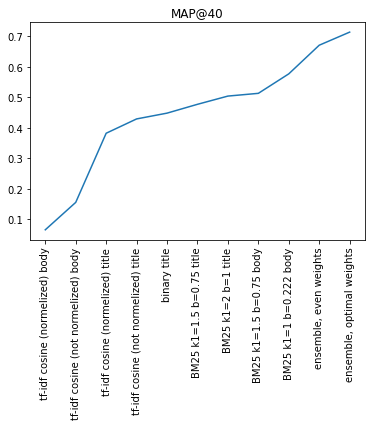

In [123]:
import matplotlib.pyplot as plt


x = ["tf-idf cosine (normelized) title", "tf-idf cosine (not normelized) title", "binary title", "BM25 k1=1.5 b=0.75 title", "BM25 k1=2 b=1 title", "tf-idf cosine (normelized) body", "tf-idf cosine (not normelized) body", "BM25 k1=1.5 b=0.75 body", "BM25 k1=1 b=0.222 body", "ensemble, even weights", "ensemble, optimal weights"]
y_eval = [0.382, 0.429, 0.448, 0.477, 0.504, 0.065, 0.155, 0.513, 0.577, 0.671, 0.714] 
y_time = [0.347, 0.319, 0.330, 0.393, 0.363, 3.89, 3.145, 3.00, 3.04, 3.541, 3.616]

uni = sorted([(x[i], y_eval[i], y_time[i]) for i in range (len(y_time))], key = lambda x: x[1])
x = [x[0] for x in uni]
y_eval = [x[1] for x in uni]
y_time = [x[2] for x in uni]

plt.plot(x, y_eval)
plt.xticks(rotation = 90)
plt.title("MAP@40")
plt.show()

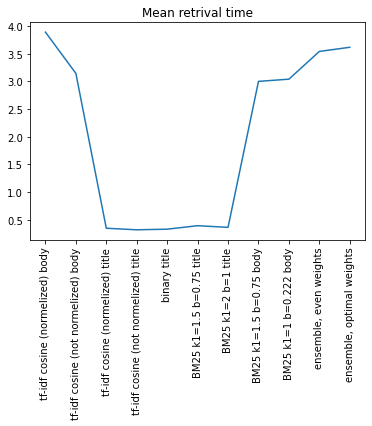

In [125]:
plt.plot(x, y_time)
plt.xticks(rotation = 90)
plt.title("Mean retrival time")
plt.show()

body

In [ ]:
import matplotlib.pyplot as plt
  
results_dict = expiraments_result_dict_title

x = ["tf-idf cosine (normelized)", "tf-idf cosine (not normelized)", "BM25 k1=1.5 b=0.75", "BM25 k1=1 b=0.222"] 
y_eval = [0.065, 0.155, 0.513, 0.577] 
y_time = [3.89, 3.145, 3.00, 3.04] 
  
# plot lines
plt.plot(x, y_eval, label = "MAP@40")
plt.plot(x, y_time, label = "mean retrןval time")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Test final solution

In [19]:
# from dicts_and_indexes import *
# from get_page_rank_backend import *
# from get_pageviews_backend import *

to_return = 100

def search_backend(query_tokens):
    title_scores = inverted_BM25_similaruty_title(query_tokens, index_title)
    body_scores = inverted_BM25_similaruty_body(query_tokens, index_body)
    anchor_scored = search_anchor_for_opt(query_tokens, index_anchor)

    scores_dict = {"title": title_scores, "body": body_scores,
                   "anchor": anchor_scored, "pageview": norm_pageviews_dict, "pagerank": norm_pagerank_dict}
    res = merge_results(scores_dict, weights_dict)  # 100 united scores
    res = [x[0] for x in res]  # give titles
    return res


#  calculating avgdl for BM25:
num_docs = len(DL_title)
sum_lengths = 0
for val in DL_title.keys(): sum_lengths += DL_title[val]
avgdl_title = sum_lengths / num_docs
num_docs = len(DL_body)
sum_lengths = 0
for val in DL_body.keys(): sum_lengths += DL_body[val]
avgdl_body = sum_lengths / num_docs


# title:
def inverted_BM25_similaruty_title(query_tokens, index, k1=2, b=1):
    N = 6348910  # num of documents in the curpus
    similarity_dict = dict()  # doc_id : cosine similarity
    for term in query_tokens:
        if term in index.words:
            posting_list = read_posting(term, index)
            df = index.df[term]
            q_i_IDF = np.log((N - df + 0.5) / (df + 0.5) + 1)
            for doc_id, freq in posting_list:
                if doc_id == 0:
                    continue
                f_ti_D = freq
                len_of_D = DL_title[doc_id]
                w = q_i_IDF * ((f_ti_D * (k1 + 1)) / (f_ti_D + k1 * (1 - b + b * (len_of_D / avgdl_title))))
                similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w
    return similarity_dict


# body:
def inverted_BM25_similaruty_body(query_tokens, index, k1=1, b=0.22222):
    N = 6348910  # num of documents in the curpus
    similarity_dict = dict()  # doc_id : cosine similarity
    for term in query_tokens:
        if term in index.words:
            posting_list = read_posting(term, index)
            df = index.df[term]
            q_i_IDF = np.log((N - df + 0.5) / (df + 0.5) + 1)
            for doc_id, freq in posting_list:
                if doc_id == 0:
                    continue
                f_ti_D = freq
                len_of_D = DL_body[doc_id]
                w = q_i_IDF * ((f_ti_D * (k1 + 1)) / (f_ti_D + k1 * (1 - b + b * (len_of_D / avgdl_body))))
                similarity_dict[doc_id] = similarity_dict.get(doc_id, 0) + w
    return similarity_dict


# anchor:
def search_anchor_for_opt(query_tokens, index):
    relavent_docs = {}
    for term in np.unique(query_tokens):
        if term in index.words:
            list_of_docs = read_posting(term, index)
            for dest_id, flag in list_of_docs:
                if dest_id == 0:
                    continue
                relavent_docs[dest_id] = relavent_docs.get(dest_id, 0) + 10
    return relavent_docs


# page views:
norm_pageviews_dict = dict()
for page in pageviews_dict:
    norm_pageviews_dict[page] = pageviews_dict[page] ** (0.25) / 3

# page rank:
norm_pagerank_dict = dict()
for page in pagerank_dict:
    norm_pagerank_dict[page] = np.sqrt(pagerank_dict[page]) / 3

# weights_dict:
weights_dict = {"title": 1, "body": 1,
                "anchor": 1/3, "pageview": 2/3, "pagerank": 1/3}


# merge:
def merge_results(scores_dict, weights_dict):
    # united for query: [(doc_id, united_score)]
    united_list = []
    score_types = list(scores_dict.keys())
    # all relevant docs for query:
    doc_ids = set()
    for score_type in score_types:
        if score_type in ["pageview", "pagerank"]:
            continue
        else:
            doc_ids = doc_ids.union(set(scores_dict[score_type].keys()))
    # calc united score
    for doc_id in doc_ids:
        doc_united_score = 0
        for score_type in score_types:
            w = weights_dict[score_type]
            if doc_id in scores_dict[score_type]:
                doc_united_score += scores_dict[score_type][doc_id] * w
        united_list.append((doc_id, doc_united_score))
    # sort:
    united_list_sorted = sorted(united_list, key=lambda x: -x[1])[:to_return]
    return united_list_sorted


In [28]:
import time
from builtins import *

weights_dict = {"title": 1, "body": 1,
                "anchor": 1/3, "pageview": 2/3, "pagerank": 1/3}
ans_map = []
ans_time = []
for query in queries_to_relavent_docs:
  t = time.time()
  query_tokens = query_preprosess(query)
  predicted_list = search_backend(query_tokens)
  tt = time.time()-t
  true_list = queries_to_relavent_docs[query]
  ans_map.append((query, round(average_precision(true_list,predicted_list,40), 3)))
  ans_time.append((query, round(tt, 3)))
  # print(query, ":")
  # print("MAP:", round(average_precision(true_list,predicted_list,40), 3))
  # print("TIME",round(tt, 3))
ans_map = sorted(ans_map, key = lambda x: -x[1])
ans_time = sorted(ans_time, key = lambda x: -x[1])
for i in ans_map:
  print(i)
print("+++++++++++++++++++++++++++++++++")
for i in ans_time:
  print(i)

('migraine', 0.986)
('yoga', 0.882)
('python', 0.866)
('ted', 0.827)
('masks', 0.765)
('chocolate', 0.738)
('NBA', 0.705)
('how google works', 0.623)
('michelin', 0.607)
('where does vanilla flavoring come from', 0.559)
('how to make pasta', 0.526)
('how to tie a tie', 0.492)
('how to vote', 0.458)
('fairy tale', 0.448)
('what is critical race theory', 0.3)
('rubber duck', 0.295)
('how to not kill plants', 0.288)
('data science', 0.28)
('how to earn money online', 0.267)
('dim sum', 0.216)
('how tall is the eiffel tower', 0.206)
('what to watch', 0.204)
('Does pasta have preservatives?', 0.167)
('google trends', 0.124)
('what is information retrieval', 0.121)
('best ice cream flavour', 0.056)
('black friday', 0.046)
('what space movie was made in 1992', 0.037)
('best marvel movie', 0.029)
('why do men have nipples', 0.0)
+++++++++++++++++++++++++++++++++
('what space movie was made in 1992', 26.277)
('best ice cream flavour', 13.074)
('best marvel movie', 12.982)
('black friday', 8.312

In [104]:
sumi / len(train_queries)

3.541758668422699

anchor